In [27]:
import numpy as np
import pandas as pd
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [28]:
import torch.nn as nn
import torch.nn.functional as F
import plotly
import plotly.graph_objs as go

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [30]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

In [31]:
import collections

In [32]:
!pip install apimoex

In [33]:
import requests
import apimoex

session = requests.Session()

In [34]:
df = pd.DataFrame(apimoex.get_board_history(session, 'MOEX')).dropna()
df = df[-1000:]
df = df.reset_index(drop=True)
print(df.head())

  BOARDID   TRADEDATE   CLOSE    VOLUME         VALUE
0    TQBR  2020-11-23  138.69  17322700  2.423848e+09
1    TQBR  2020-11-24  141.38  12546910  1.761728e+09
2    TQBR  2020-11-25  142.78  16830990  2.392818e+09
3    TQBR  2020-11-26  146.86  17330920  2.524341e+09
4    TQBR  2020-11-27  153.10  30169090  4.567858e+09


In [35]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df['CLOSE'][:],
    line =  dict(shape =  'spline' ),
    name = 'Курс акции MOEX'
            ))
fig.show()

In [36]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, train_data, test_data, normalize = True, noise = True):
        self.train_length = train_data.shape[0]
        self.test_length = test_data.shape[0]
        self.data = np.concatenate([train_data.flatten(), test_data.flatten()])


        if noise:
            # add a noise
            self.data += np.random.normal(0, 0.05, size = self.data.shape)*self.data
        if normalize:
            # minmax normalization
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        We return the derivatives of a separate window in our selection
        and remove the zeros at the beginning
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 1):
        """
        0 => long   1 => short
        """
        if action == 0:
            action = -1
        elif action == 1:
            action = 1

        # We pull out the current price
        price_now = self.data[action_time]
        # We pull out the next price
        price_reward = self.data[reward_time]
        # We get the difference
        price_diff = (price_reward - price_now)
        # We add the following number to the portfolio:
        # Delta of currency change * buy/sell/hold * purchase ratio
        reward = price_diff * action * coef

        return reward

We don't want to study trading, we need to develop intuition to predict the price. Thus, a small simple NN is needed.

In [37]:
# define the nn architecture
class Net(nn.Module):
    """Строим простую модель нейронки"""
    def __init__(self, state_shape, action_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_shape, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, action_shape)
        self.drop = nn.Dropout(0.2)

    def forward(self, x):
        x = self.fc2(self.drop(F.gelu(self.fc1(x))))
        x = self.fc3(self.drop(F.gelu(x)))
        return x

In [38]:
class BuyHoldSellAgent:
    '''
        Агент для покупки продажи
    '''
    def __init__(self, state_shape = 10, action_shape = 2, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.experience = collections.deque(maxlen=self.experience_size)

        # Creating an instance of the model
        self.model = Net(state_shape, action_shape)

        # Let's create an error function
        self.criterion = nn.HuberLoss()
        # Let's add an optimizer
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-3)

    def save_experience(self, current_state, action, reward, next_state):
        """A method for saving previous experimental data"""
        self.experience.append({
            'state_i': current_state,
            'action_i': action,
            'reward_i': reward,
            'state_i_1': next_state
        })

    def replay_experience(self, gamma, sample_size):
        """A method for optimizing training data"""
        # Creating a fixed selection from the added events
        indices_sampled = np.random.choice(
            len(self.experience),
            sample_size,
            replace=False
        )
        # We are going through only those elements that were added to the selection

        current_states = []
        actions = []
        rewards = []
        next_states = []
        for i in indices_sampled:
            state_i, action_i, reward_i, state_i_1 = self.experience[i]['state_i'], self.experience[i]['action_i'], self.experience[i]['reward_i'], self.experience[i]['state_i_1']
            current_states.append(state_i)
            actions.append(action_i)
            rewards.append(reward_i)
            next_states.append(state_i_1)

        current_states = np.array(current_states).squeeze()
        next_states = np.array(next_states).squeeze()

        # We get a forecast for the following state
        next_q_values = self.model(torch.from_numpy(next_states).float()).detach().numpy()

        # we get a forecast for the current state
        current_q_values = self.model(torch.from_numpy(current_states).float()).detach().numpy()
        # The Bellman equation
        for i in range(len(indices_sampled)):
            # we enter it in the Q table for training
            current_q_values[i, actions[i]] = rewards[i] + gamma * next_q_values[i, :].max()

        outputs = self.model(torch.from_numpy(np.expand_dims(current_states.reshape(-1, WINDOW_SHAPE), 0)).float())[0]
        loss = self.criterion(outputs, torch.Tensor(current_q_values))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_value_action_value(self, state):
        """Метод для прогноза сигнала"""
        state = np.expand_dims(state, axis = 0)
        pred = self.model(torch.from_numpy(state).float())
        return pred.flatten()

In [39]:
# number of epochs
epochs = 100
# The significance of the award is one step ahead
gamma = 0.95
# initial epsilon
epsilon = 1.0
# epsilon_decay
alpha_e = 0.97

In [40]:
# dataset size
DATASET_LENGTH = len(df['CLOSE'])
# The size of the window from which the previous data will be taken
WINDOW_SHAPE = 40
# Previous data step
REWARD_TIME = 1
# number of action
ACTIONS_SHAPE = 2
# Sample size
SAMPLE_SIZE = 100
EXP_SIZE = 100
# test size
SIZE_test = 50


In [41]:
action_to_backtest_action = {
    1: 1,  # buy
    0: -1,  # sell
}

In [42]:
train_dataset = np.array(df['CLOSE'][:-SIZE_test])
test_dataset = np.array(df['CLOSE'][-SIZE_test:])

In [43]:
# We prescribe a new environment and transmit data on the closing price
environment = Environment(train_dataset, test_dataset, normalize = True, noise =True)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE, EXP_SIZE)

In [44]:
set_random_seed(42)


for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, environment.train_length - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Get the current state. Derivatives in a separate interval
        # The current Y on the graph and the previous WINDOW_SHAPE steps
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # We get a prediction for this state through the model
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Select an action for the current state
        # Depending on the length of the epsilon, we choose a random action
        # or real ones according to predictions
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. We receive a reward for the selected action
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. We get the future state. Derivatives in the future interval
        # The current Y + 1 on the graph and the previous WINDOW_SHAPE steps
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. We save all the received data of the agent
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. As soon as the number of previously received samples has exceeded
        # for what is necessary, we begin to train the network
        if j > SAMPLE_SIZE * 2:
            agent.replay_experience(gamma, SAMPLE_SIZE)

    # With each step, we decrease the epsilon so that the bot begins to act
    # according to his own forecasts, he stopped studying the environment
    epsilon *= alpha_e

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... 0.0019077639659788542
Epoch 1 ... 0.0017728713570634705
Epoch 2 ... -0.0011109775404039173
Epoch 3 ... -0.001179437654151737
Epoch 4 ... 6.562098217184129e-05
Epoch 5 ... 0.0011773332380110248
Epoch 6 ... -0.0019505666845487778
Epoch 7 ... 0.0013606872868967869
Epoch 8 ... 0.0014572354666974557
Epoch 9 ... 0.00288868986251706
Epoch 10 ... -0.0012418907960037174
Epoch 11 ... -0.002753025312252127
Epoch 12 ... -0.00047702576498970283
Epoch 13 ... 0.0013411928741382524
Epoch 14 ... -0.00044483268401749796
Epoch 15 ... -0.0017857460792585428
Epoch 16 ... 0.0015023113891925322
Epoch 17 ... -0.00011846124529503507
Epoch 18 ... 0.0005759145215510874
Epoch 19 ... 0.0022139048480369658
Epoch 20 ... -7.563983181263824e-06
Epoch 21 ... 0.0021758455630470496
Epoch 22 ... 0.0012297373815834357
Epoch 23 ... 0.0004826893458242863
Epoch 24 ... 0.0019441164378263664
Epoch 25 ... -0.000900511191785861
Epoch 26 ... -0.0011690450724435872
Epoch 27 ... 0.0021849730271709437
Epoch 28 ... 0.00232

In [47]:
actions = []

for j in range(WINDOW_SHAPE, len(df['CLOSE']), REWARD_TIME):
    # 1. We obtain derivatives in a separate interval
    # Current price and previous WINDOW_SHAPE steps
    state_j = environment.get_state(j, WINDOW_SHAPE)

    # We get the prediction of the bot according to the data
    q_value_j = agent.get_value_action_value(state_j)
    # We define the signal and record it in events
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

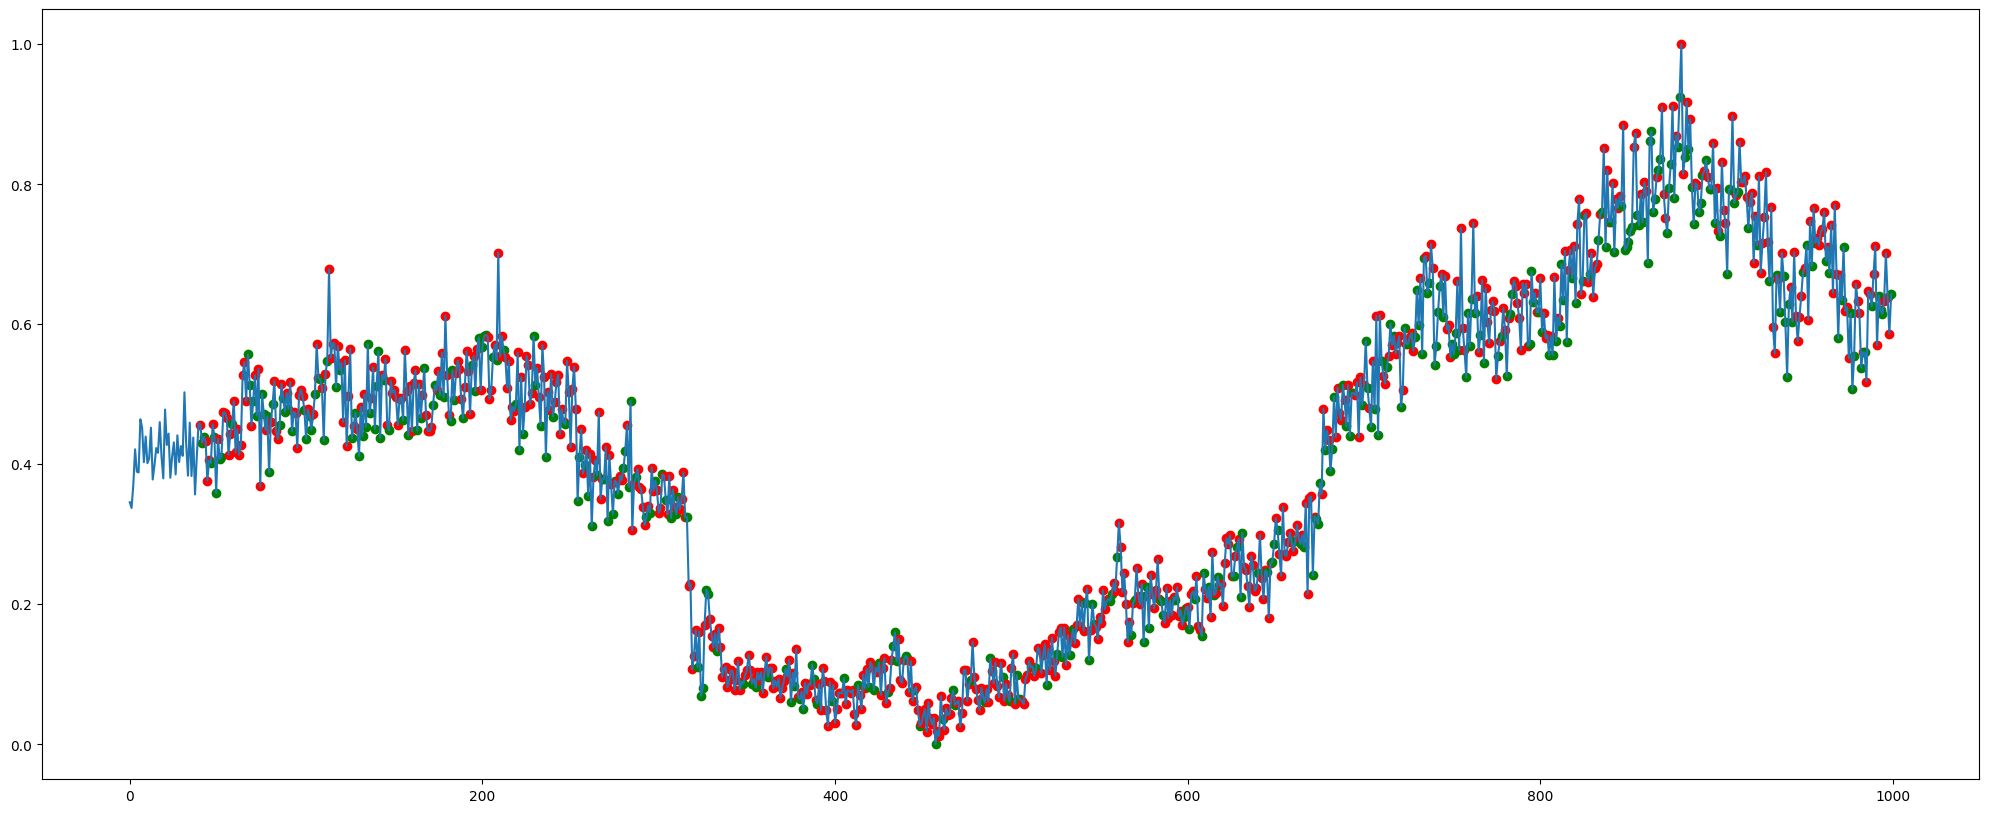

In [48]:
plt.figure(figsize = (25, 10))
dataf = environment.data[::REWARD_TIME]
plt.plot(dataf)
for e, a in enumerate(actions):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE//REWARD_TIME
    if a == 1:
        plt.scatter(e, dataf[e], color = 'green')
    elif a == -1:
        plt.scatter(e, dataf[e], color = 'red')

plt.show()

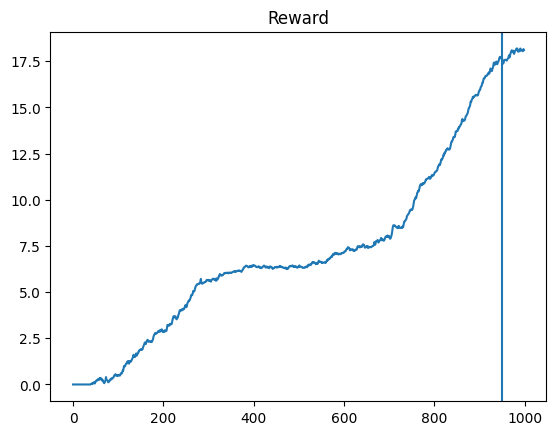

In [49]:
 # We make a schedule of income. Let's make a frame of the Price format/The signal
backtest = pd.DataFrame({
    'price': dataf.flatten(),
    'signal': [0] * (WINDOW_SHAPE//REWARD_TIME) + actions
})
# We get price derivatives and make a shift
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# We summarize the income and display a graph
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Reward')

plt.axvline(x=(dataf.shape[0]-SIZE_test)//REWARD_TIME)
plt.show()